# What is the hidden sub-topics under the umbrella of data science? How have they evolved over the course of 30 year?

## 1. Method
### 1.1 Topic Modelling
Topic modelling is a technique to extract hidden topics from a large size of corpus. There are many ways to conduct topic modeling analysis and one of them is Latent Dirichlet Allocation. LDA treats each document as the distributions of topics and each topic as the distributions of words. Therefore, a document has a mixture of topics instead of being categorized into a discrete group, which in a way reflects the typical use of natural language. Hierarchical Dirichlet Process (HDP) is an extension of LDA. While the underlying statistical principle is the same, the number of topics is given to a LDA model before training while a HDP model figures out the best number of topics during the training process. In our project, we employed HDP model from `tomotopy` Python package to conduct topic modeling analysis for the 30 years of data science paper abstracts. In addition, we will provide a deeper analysis to the topics generated in the year of 2020.

### 1.2 Data Preparation
180,962 entries of data science paper abstracts were downloaded through Azure Databricks. The text data was preprocessed by removing digits, punctuations and stop-words. Lowercasing and stemming were also applied to the text tokens. The data is then divided into four subsets based on the year published in a 10 years interval. Abstracts from 1990 to 1999 are in one subset; 2000 to 2009, 2010 to 2014, and 2014 to 2019 are each in their own subsets. Finally, abstracts from the year 2020 are in its own subset. 

In [ ]:
import pandas as pd
import numpy as np
import tqdm
import sys
import tomotopy as tp
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [ ]:
df_papers = pd.read_csv ('Data/DS/Azure_Papers.csv', low_memory=False)
df_abstrs = pd.read_csv ('Data/DS/Azure_PaperAbstracts.csv', low_memory=False)

# set new headers
new_header = df_abstrs.iloc[0] 
df_abstrs = df_abstrs[1:] 
df_abstrs.columns = new_header 

# Merge paper and abstracts
df_abstrs.PaperId = df_abstrs.PaperId.astype(int)
df = pd.merge(left=df_papers, right=df_abstrs, left_on='PaperId', right_on='PaperId')
df = df[["PaperId","PaperTitle","Year", "IndexedAbstract"]]

In [ ]:
# create df from different decades
df_90s = df[(df['Year'] >= 1990) & (df['Year'] < 2000)]
df_00s = df[(df['Year'] >= 2000) & (df['Year'] < 2010)]
df_10s = df[(df['Year'] >= 2010) & (df['Year'] < 2015)]
df_15s = df[(df['Year'] >= 2015) & (df['Year'] < 2020)]
df_20s = df[(df['Year'] >= 2020)]

In [ ]:
import re
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))

# Add MAG keys to stopword set to be removed
extra_words = ['indexlength', 'invertedindex']

for word in extra_words:
    stop_words.add(word)

ps = PorterStemmer()

def tokenize(input_str):
    # lower case
    input_str = input_str.lower()
    
    # remove non-English words
    input_str  = re.sub("([^\x00-\x7F])+"," ",input_str)

    # remove numbers
    input_str = re.sub(r'\d+', '', input_str)
    
    # Replace comma to space
    input_str = re.sub(r':', ' ', input_str)

    # remove punc
    input_str = input_str.translate(str.maketrans(' ',' ',string.punctuation))
    
    # Remove apostrophe
    input_str = re.sub(r"'", '', input_str)

    # remove stopwords
    input_str = word_tokenize(input_str)
    input_str = [i for i in input_str if not i in stop_words]
    
    return input_str

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def clean_text(input_str):
    tokens = tokenize(input_str)
    tokens = [get_lemma(token) for token in tokens]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kelichiu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Text cleaning and tokenization
processed_docs_all = df['IndexedAbstract'].map(clean_text)
processed_docs_00s = df_00s['IndexedAbstract'].map(clean_text)
processed_docs_90s = df_90s['IndexedAbstract'].map(clean_text)
processed_docs_00s = df_00s['IndexedAbstract'].map(clean_text)
processed_docs_10s = df_10s['IndexedAbstract'].map(clean_text)
processed_docs_15s = df_15s['IndexedAbstract'].map(clean_text)
processed_docs_20s = df_20s['IndexedAbstract'].map(clean_text)

### 1.3 Model Training
The HDP Topic Model object is provided by `tomotopy` Python package. The model is initiated by setting parameters 
that has affects on how the model weights tokens, sets thresholds for token frequency, and the HDP model’s concentration parameters — alpha and beta. Once the model object is instantiated, the data science paper abstracts are used to rain the model. During the training process, we print out the number of iteration, the per-word log-likelihood, and the number of topics generated as the early-diagnostic information.

In [ ]:
# Build gensim objects
def define_hdp_model(processed_docs, alpha, eta , initial_k ):
    hdp = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=10, rm_top=12,
                alpha=alpha, eta=eta, initial_k=initial_k, seed=99999)
    # Add docs to train
    for vec in processed_docs:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    
    return hdp

# Train model
def train_hdp_model(hdp):
    mcmc_iter=1000
    for i in range(0, mcmc_iter, 100):
        hdp.train(100, workers=3)
        print('Iteration: {}\tLog-likelihood: {}\t# of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
    return hdp

def get_hdp_topics(hdp, top_n=10):
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

def extract_topics(processed_docs, hdp_topics):
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in hdp_topics.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)

        topic_list.append(topic_tokens)
    return topic_list


### 1.4 Model Evaluation
Since HDP Topic Modeling is unsupervised, accuracy score is not applicable for evaluating the model. Instead, we look at the coherence score, which is an statistical measure of the topic model performance. A topic has a higher score of coherence if the words defining a topic have a high probability of co-occurring cross documents. The target coherence score is > 0.5. Cross validation is not performed because the objective is to study the topics within the dataset; therefore, generalizability is not of concern. 

In [ ]:
def get_conherence_score(processed_docs, alpha, eta, initial_k):
    
    #define the model
    hdp =  define_hdp_model(processed_docs, alpha, eta, initial_k)
    #define the model
    train_hdp_model(hdp)
    #get topics
    hdp_topics = get_hdp_topics(hdp, top_n=10)
    #get topic list
    topic_list = extract_topics(processed_docs, hdp_topics)
    
    vocab = corpora.Dictionary(processed_docs)
    corpus = [vocab.doc2bow(words) for words in processed_docs]

    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=processed_docs, 
                        coherence='c_v')
    cm = cm.get_coherence()
    
    print("Topic distributions: ", hdp_topics)
    print("Topics: ", topic_list)
    print("Coherence score: ", cm)
    return cm, topic_list, hdp_topics

### 1.5 Hyperparameter Tuning
For the tuning, grid search is performed with three hyperparameters. Alpha is the coefficient that affects the distribution of topics in the abstracts with the intervals of 0.01, 0.31, 0.61 and 0.91. Beta is the coefficient that affects the distribution of words in topics and it has the same intervals with the alpha. Initial k is the number of topics we give to the model as a start, we set the intervals to 5, 6, 7 and 8. The total iteration for grid search is 4x4x4 = 64. The result of the Grid Search is presented in section 3.1.

In [ ]:
# === Grid search and tuning ===
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
# Beta parameter
eta = list(np.arange(0.01, 1, 0.3))
# Initial K
#initial_k = list(np.arange(5, 8, 1))
initial_k = list(np.arange(7, 10, 1))
model_results = {'alpha': [],
                 'beta': [],
                 'initial_k': [],
                 'coherence': []
                }

def grid_search(processed_docs, time):
    if 1 == 1:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in eta:
                for k in initial_k:
                    # get the coherence score for the given parameters
                    cv = get_conherence_score(processed_docs, a, b, k)[0]
                    # Save the model results
                    model_results['alpha'].append(a)
                    model_results['beta'].append(b)
                    model_results['initial_k'].append(k)
                    model_results['coherence'].append(cv)
                    print('coherence score:', cv, ', alpha:', a, ', beta:', b, ', initial_k:', k)
        print("###### End of Grid Search ######")
        pd.DataFrame(model_results).to_csv('hdp_tuning_results_'+time+'.csv', index=False)

In [ ]:
grid_search(processed_docs_90s, '90')
grid_search(processed_docs_00s, '00')
grid_search(processed_docs_10s, '10')
grid_search(processed_docs_15s, '15')
grid_search(processed_docs_20s, '20')

## 2. Exploratory Data Analysis
### 2.1 Distribution of Abstract Word Counts
The following histogram shows the distribution of abstract word counts in the data science field. The average number of word in an abstract is 70. While 99% of the abstracts have less than 220 words, the abstract with the largest word counts has 629 words. 

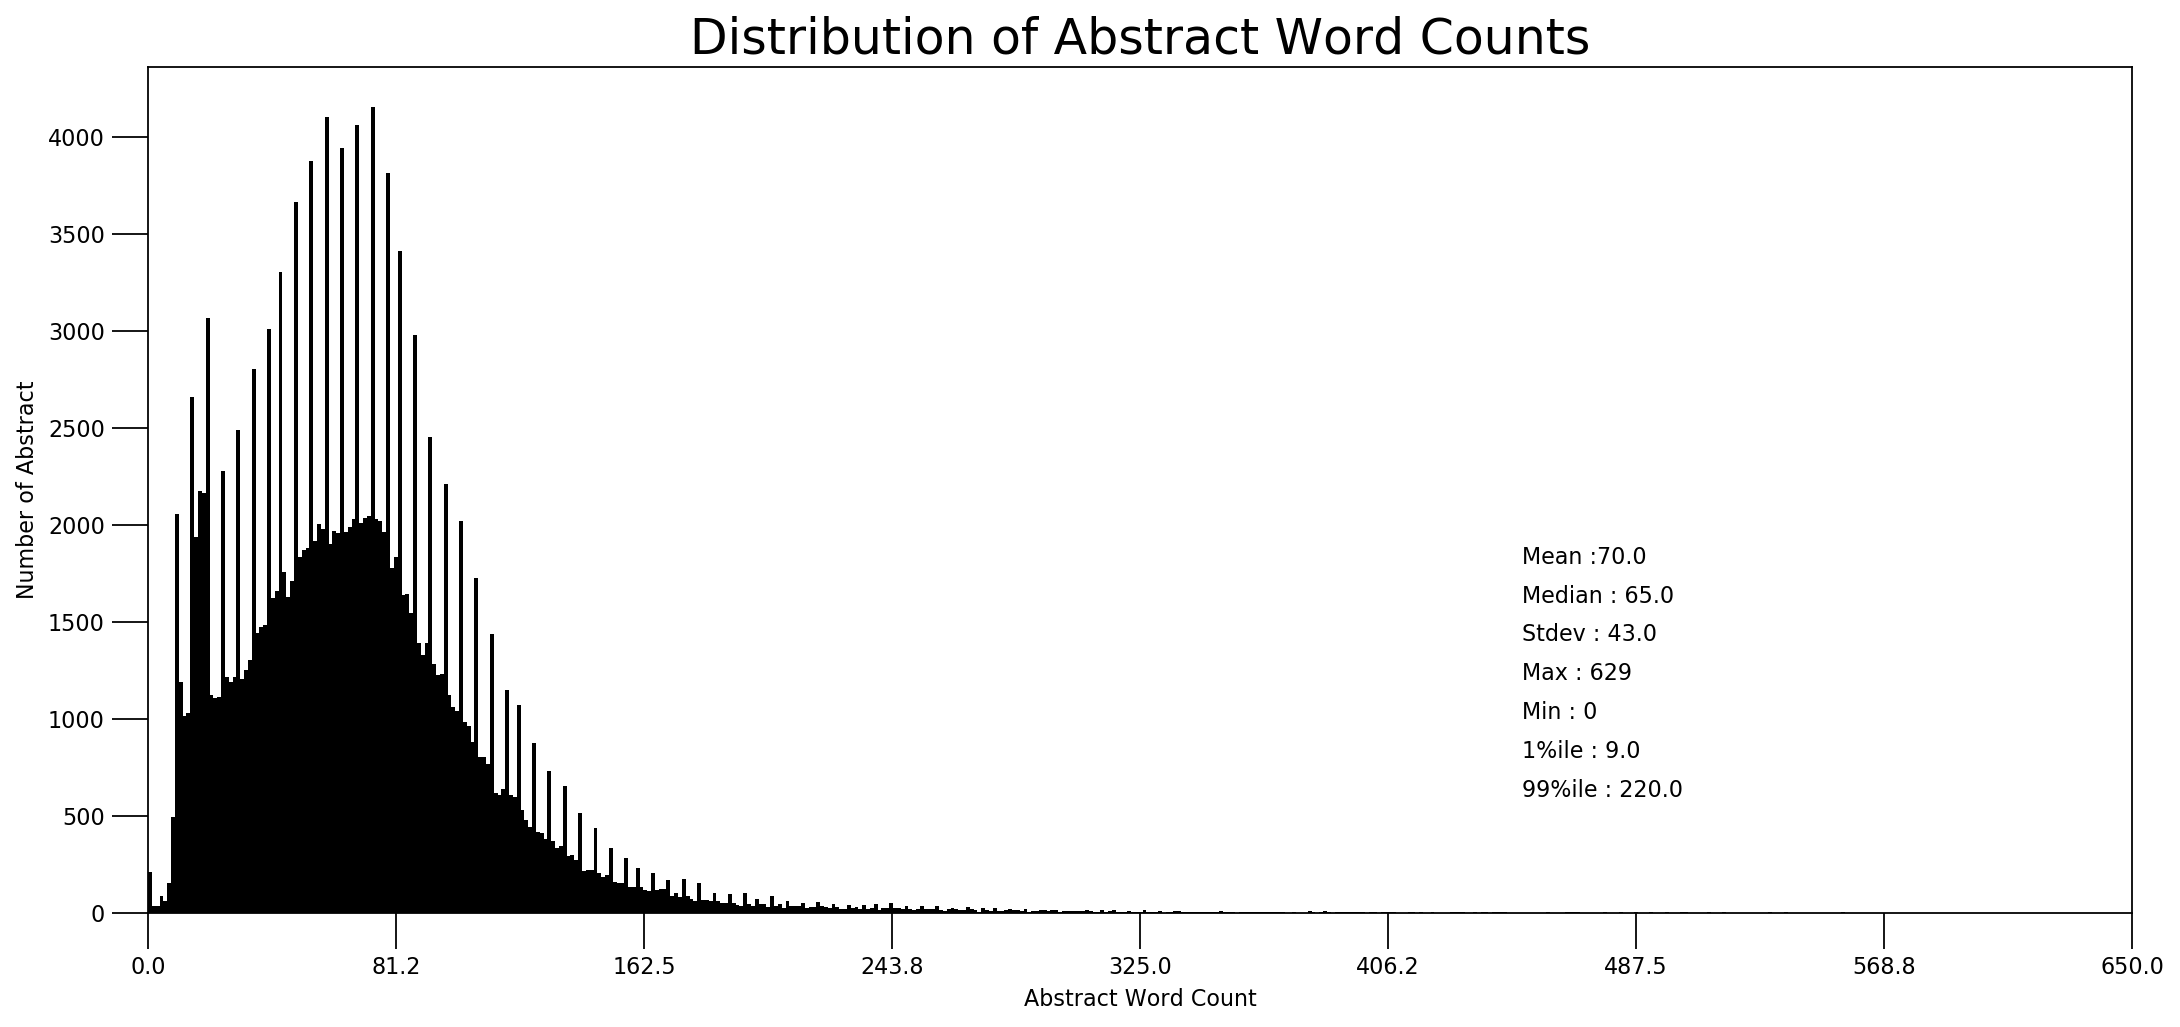

In [ ]:
import matplotlib.pyplot as plt
doc_lens = [len(d) for d in processed_docs_all]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 500, color='#000000')
plt.text(450,  1800, "Mean :" + str(round(np.mean(doc_lens))))
plt.text(450,  1600, "Median : " + str(round(np.median(doc_lens))))
plt.text(450,  1400, "Stdev : " + str(round(np.std(doc_lens))))
plt.text(450,  1200, "Max : " + str(round(np.max(doc_lens))))
plt.text(450,  1000, "Min : " + str(round(np.min(doc_lens))))
plt.text(450,  800,  "1%ile : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(450,  600,  "99%ile : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 650), ylabel='Number of Abstract', xlabel='Abstract Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,650,9))
plt.title('Distribution of Abstract Word Counts', fontdict=dict(size=22))
plt.show()

### 2.2 Top 20 word pairs in different times
To explore the data, we look at the top 20 most frequently used word pairs in the five different time periods. It is interesting to see that "data warehousing" was already a popular subject in the 1990s. "Machine learning" only became popular in the 2010s. "Big data" is the most frequent word pair in the last decade and also this year. "Covid pandemic", as expected, also appeared on the list of 2020. These pairs of words give us an rough idea of what scholars were talking about within the field of data science. 

<Figure size 432x288 with 0 Axes>

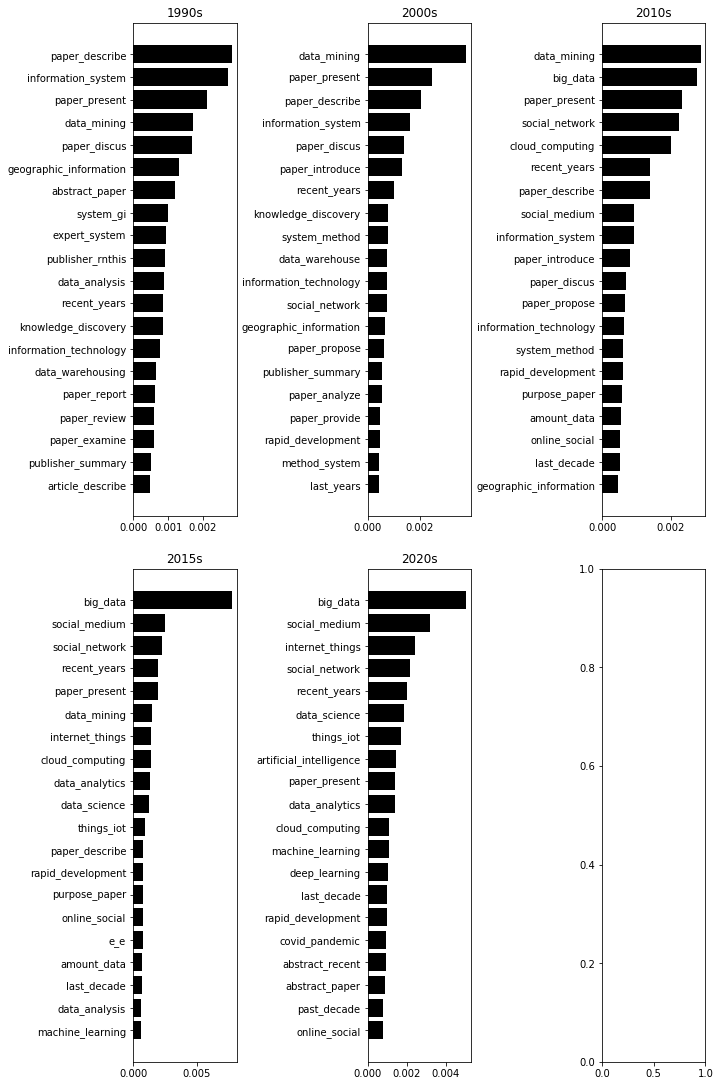

In [ ]:
# Define a function that makes bi-grams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from operator import itemgetter
def make_bigram(processed_docs):
    
    words = processed_docs.to_string()
    words = clean_text(words)
    
    # setup and score the bigrams using the raw frequency.
    finder = BigramCollocationFinder.from_words(words)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    # Sort highest to lowest based on the score.
    scoredList = sorted(scored, key=itemgetter(1), reverse=True)

    word_dict = {}

    listLen = len(scoredList)

    # Set the key to the scored value
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
    return word_dict

# Make bi-grams
word_dict_90 = make_bigram(processed_docs_90s)
word_dict_00 = make_bigram(processed_docs_00s)
word_dict_10 = make_bigram(processed_docs_10s)
word_dict_15 = make_bigram(processed_docs_15s)
word_dict_20 = make_bigram(processed_docs_20s)

# Get top 20 most frequent bi-grams
def get_top_ngrams(word_dict, top_n):
    bigrams = list(word_dict.items())[:top_n]
    bigrams = sorted(bigrams, key=lambda x:x[1], reverse = False)
    return bigrams
bigrams_90s = get_top_ngrams(word_dict_90, 20)
bigrams_00s = get_top_ngrams(word_dict_00, 20)
bigrams_10s = get_top_ngrams(word_dict_10, 20)
bigrams_15s = get_top_ngrams(word_dict_15, 20)
bigrams_20s = get_top_ngrams(word_dict_20, 20)

import matplotlib.pyplot as plt

x90, y90 = zip(*bigrams_90s)
x00, y00 = zip(*bigrams_00s)
x10, y10 = zip(*bigrams_10s)
x15, y15 = zip(*bigrams_15s)
x20, y20 = zip(*bigrams_20s)

fig = plt.figure()
fig, axs = plt.subplots(2, 3, figsize=(10,15))
plt.tight_layout()
axs[0, 0].barh(x90, y90, color=("#000000"))
axs[0, 0].set_title("1990s")
axs[0, 1].barh(x00, y00, color=("#000000"))
axs[0, 1].set_title("2000s")
axs[0, 2].barh(x10, y10, color=("#000000"))
axs[0, 2].set_title("2010s")
axs[1, 0].barh(x15, y15, color=("#000000"))
axs[1, 0].set_title("2015s")
axs[1, 1].barh(x20, y20, color=("#000000"))
axs[1, 1].set_title("2020s")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

## 3. Analysis
### 3.1 Grid Search Result for Hyperparameter Tuning
Grid search result indicates that the following values for the hyperparameters yield the best coherence scores. Each models has different values for the hyperparameter. The data with larger amount of abstracts has higher values for initial_k, which is the initial number of topics given to the model. All the models achieved the goal of coherence score higher than 0.5.

In [ ]:
times = ["90", "00", "10", "15", "20"]
def get_tuning_result():
    bests = pd.DataFrame()
    for i in range(len(times)):
        result = pd.read_csv('hdp_tuning_results_'+times[i]+'.csv', low_memory=False)
        bests = bests.append(result.sort_values(by=['coherence'], ascending=False)[:1])
    bests["time"] = times
    results = bests.to_csv("tuning_results.csv", index=False)
    return
get_tuning_result()

pd.read_csv("tuning_results.csv")

,alpha,beta,initial_k,coherence,time
0,0.61,0.61,7,0.587362,90
1,0.01,0.91,8,0.625250,0
2,0.01,0.91,9,0.640976,10
3,0.91,0.61,9,0.696691,15
4,0.61,0.61,7,0.731816,20


### 3.2 Output Topics
What the model generates are a bunch of words that appear together in a topic, and it relies on human interpretation to make sense out of them. The following tables display both the machine output topics and human interpretations as the label of the topics.

In [ ]:
result90 = get_conherence_score(processed_docs_90s, 0.61, 0.61, 7)
result00 = get_conherence_score(processed_docs_00s, 0.01, 0.91, 8)
result10 = get_conherence_score(processed_docs_10s, 0.01, 0.91, 9)
result15 = get_conherence_score(processed_docs_15s, 0.91, 0.61, 9)
result20 = get_conherence_score(processed_docs_20s, 0.61, 0.61, 7)

Training...


Num docs: 39891 , Vocab size: 9458 , Num words: 2238061
Removed top words: ['data', 'system', 'information', 'use', 'research', 'paper', 'analysis', 'provide', 'model', 'technology', 'application', 'method']
Iteration: 0	Log-likelihood: -30.138181266641777	# of topics: 9
Iteration: 100	Log-likelihood: -30.137833366211964	# of topics: 9
Iteration: 200	Log-likelihood: -30.137634630986486	# of topics: 9
Iteration: 300	Log-likelihood: -30.13720221904682	# of topics: 9
Iteration: 400	Log-likelihood: -30.136964452470306	# of topics: 9
Iteration: 500	Log-likelihood: -30.138011477131485	# of topics: 9
Iteration: 600	Log-likelihood: -30.137398915906534	# of topics: 9
Iteration: 700	Log-likelihood: -30.137628622942373	# of topics: 10
Iteration: 800	Log-likelihood: -30.1365251425165	# of topics: 10
Iteration: 900	Log-likelihood: -30.13570468740608	# of topics: 10
Topic distributions:  {7: [('knowledge', 0.002921890700235963), ('mining', 0.0027241550851613283), ('process', 0.0026896800845861435), 

In [ ]:
def display_topics(result, time):
    topic_list = result[1]
    topic_list = pd.Series( (v for v in topic_list) )
    topic_list = topic_list.to_frame()
    topic_list.columns =["Topic " + time]
    pd.set_option('display.max_colwidth', 1)
    return topic_list

#### 1990—1999
The model generated 10 topics in the field of data science between year 1990 to 1999. The result shows that data science topics in the 1990s are already crossing different domains such as statistics, biology and health care. However, half of the topics such as knowledge base, database management, questionnaire and interview measure seem to be of methods and techniques whose domains are not clearly revealed. Two topics are not identifiable by human interpretation because they are mixed of non-English words and do not communicate any semantic meaning.

In [ ]:
display_topics_90 = display_topics(result90, "1990-1999")
human_labels_90 = ["Knowledge base and design process", 
                   "Database management and data mining",
                   "Biology and genome sequence",
                   "Data collection in health care",
                   "National science and technology centers",
                   "Questionnaire and interview measure",
                   "Statistical publications",
                   "Unidentifiable",
                   "Unidentifiable"
                ]
display_topics_90["human label"] = human_labels_90
display_topics_90

,Topic 1990-1999,human label
0,"[study, method, knowledge, process, approach, result, base, present, design, technique]",Knowledge base and design process
1,"[database, technology, gi, management, tool, knowledge, mining, environment, user, process]",Database management and data mining
2,"[science, biology, biological, sequence, genome, new, molecular, technology, many, computer]",Biology and genome sequence
3,"[patient, record, health, care, medical, clinical, standard, database, collection, need]",Data collection in health care
4,"[science, center, project, community, university, library, technology, scientific, national, network]",National science and technology centers
5,"[study, measure, group, child, result, questionnaire, interview, factor, variable, investigate]",Questionnaire and interview measure
6,"[book, chapter, statistics, student, text, include, reader, edition, statistical, publisher]",Statistical publications
7,"[graphic, nn, embedinlinegraphicgifn, embedinlinegraphicgif, nnrating, embedgraphicgifn, nnisbn, pp, man, press]",Unidentifiable
8,"[datanntag, datacab, tag, nntag, des, le, en, territory, dr, policy]",Unidentifiable


#### 2000—2009
The model generated 10 topics in the field of data science between year 2000 to 2009. The domains of the topics expands to include GIS mapping and spatial analysis, social network theory, pharmaceutical industry and brain disease. Two topics are not identifiable by human interpretation because they do not communicate any semantic meaning. 

In [ ]:
display_topics_00 = display_topics(result00, "2000-2009")
human_labels_00 = ["Knowledge mining", 
                   "GIS mapping and spatial analysis",
                   "Statistical publications",
                   "Bioinformatics and genome sequence",
                   "Social network theory",
                   "Clinical survey study",
                   "Chemical compounds and drug discovery",
                   "Unidentifiable",
                   "Brain and associated diseases",
                   "Unindentifiable"
                    ]
display_topics_00["human label"] = human_labels_00
display_topics_00

,Topic 2000-2009,human label
0,"[knowledge, mining, process, approach, user, problem, present, base, ontology, technique]",Knowledge mining
1,"[gi, spatial, science, resource, grid, project, management, map, scientific, geographic]",GIS mapping and spatial analysis
2,"[journal, science, citation, article, papers, author, library, statistics, book, topic]",Statistical publications
3,"[biology, gene, biological, protein, genome, molecular, sequence, bioinformatics, disease, genomics]",Bioinformatics and genome sequence
4,"[network, social, study, theory, space, interaction, change, science, approach, structure]",Social network theory
5,"[study, survey, health, patient, result, care, sample, clinical, measure, review]",Clinical survey study
6,"[drug, screening, compound, discovery, target, chemistry, pharmaceutical, chemical, molecule, hts]",Chemical compounds and drug discovery
7,"[graphic, embedinlinegraphicgifn, nn, unit, pp, university, embedinlinegraphicgif, western, health, isbn]",Unidentifiable
8,"[seizure, epilepsy, rat, subunit, se, lobe, hippocampus, n, brain, aeds]",Brain and associated diseases
9,"[rn, windows, spss, ttest, w, new, base, result, tool, development]",Unindentifiable


#### 2010—2014
The model generated 10 topics in the field of data science between year 2010 to 2014. The emergence of cloud computing is reflected in the scholar activity. Social network, geospatial study, biology and health care remained relevant topics within the field of data science. Four topics are not identifiable by human interpretation because they are too general to be distinctive or are mixed with non-English words. 

In [ ]:
display_topics_10 = display_topics(result10, "2010-2014")
human_labels_10 = ["Cloud computing", 
                   "Social network mining",
                   "Statistical education",
                   "Biology and genome sequence",
                   "Health care",
                   "unidentifiable",
                   "Geospatial study of city and environment",
                   "unidentifiable",
                   "unidentifiable",
                   "unidentifiable"
                    ]
display_topics_10["human label"] = human_labels_10
display_topics_10
# Interpretation might be overly subjective, or inaccurate due to the lack of domain knowledge

,Topic 2010-2014,human label
0,"[technology, application, process, computing, cloud, challenge, knowledge, approach, need, problem]",Cloud computing
1,"[network, social, user, propose, opinion, mining, event, show, approach, result]",Social network mining
2,"[student, learning, course, survey, result, statistical, question, education, statistics, design]",Statistical education
3,"[biology, sequence, biological, disease, gene, protein, molecular, genome, drug, tool]",Biology and genome sequence
4,"[patient, health, clinical, disease, care, medical, record, healthcare, hospital, electronic]",Health care
5,"[journal, citation, publication, article, science, author, papers, patent, library, scientific]",unidentifiable
6,"[gi, spatial, map, geographic, space, geospatial, project, city, tool, environmental]",Geospatial study of city and environment
7,"[conference, workshop, papers, hold, international, science, th, computing, topic, application]",unidentifiable
8,"[concentration, temperature, reproduction, commons, unrestricted, attribution, water, license, estimate, material]",unidentifiable
9,"[la, v, se, de, ch, para, en, na, el, que]",unidentifiable


#### 2015—2019
The model generated 11 topics in the field of data science between year 2015 to 2019. The topic domains did not grow as much but they appear to be more specific in terms of subjects. For example, the topic of social network is now linked to a specific platform — Twitter. Four topics are not identifiable by human interpretation because they are too general to be distinctive or are mixed with non-English words.

In [ ]:
display_topics_15 = display_topics(result15, "2015-2019")
human_labels_15 = ["Cloud computing and big data analytics", 
                   "Unidentifiable", 
                   "Social network and sentiment analysis with Twitter",
                   "Citation network",
                   "Biology and genome sequence",
                   "Education",
                   "Public health surveillance",
                   "Geospatial urban study",
                   "Scientific community and metadata standard",
                   "Unidentifiable",
                   "Unidentifiable",
                   "Unidentifiable"
                  ]
display_topics_15["human label"] = human_labels_15
display_topics_15

,Topic 2015-2019,human label
0,"[big, technology, application, analytics, challenge, cloud, computing, process, business, management]",Cloud computing and big data analytics
1,"[process, approach, design, question, tool, practice, problem, present, theory, work]",Unidentifiable
2,"[network, social, user, medium, opinion, sentiment, twitter, propose, online, event]",Social network and sentiment analysis with Twitter
3,"[citation, journal, publication, papers, science, article, author, scientific, topic, network]",Citation network
4,"[disease, sequence, medicine, biological, drug, biology, clinical, molecular, gene, genome]",Biology and genome sequence
5,"[student, learning, course, education, educational, analytics, university, learner, teaching, teacher]",Education
6,"[health, patient, disease, care, record, clinical, population, surveillance, medical, identify]",Public health surveillance
7,"[spatial, map, gi, city, geographic, urban, geospatial, space, area, mapping]",Geospatial urban study
8,"[science, project, community, access, repository, resource, scientific, infrastructure, standard, metadata]",Scientific community and metadata standard
9,"[e, dado, de, para, que, como, na, pesquisa, das, la]",Unidentifiable


#### Year 2020
The model generated 7 topics in the field of data science for this year. Cloud computing, social network and biology are longstanding topics within the field of data science. The topic domain also extended to city and urban mobility pattern. As expected, Covid pandemic is well discussed by the scholars this year. One topic is not identifiable by human interpretation because it is too general to be distinctive.

In [ ]:
display_topics_20 = display_topics(result20, "2020")
human_labels_20 = ["Cloud computing and internet of things",
                   "Social network and sentiment analysis with Twitter",
                   "Unidentifiable",
                   "Biology, medicine and disease",
                   "Citation network",
                   "Covid pandemic",
                   "City and urban mobility pattern"
                  ]
display_topics_20["human label"] = human_labels_20
display_topics_20

,Topic 2020,human label
0,"[technology, application, iot, big, challenge, computing, analytics, process, cloud, learning]",Cloud computing and internet of things
1,"[network, social, user, medium, propose, online, opinion, sentiment, twitter, platform]",Social network and sentiment analysis with Twitter
2,"[science, process, tool, student, practice, project, design, describe, need, present]",Unidentifiable
3,"[disease, sequence, clinical, drug, medicine, biological, molecular, biology, advance, tool]","Biology, medicine and disease"
4,"[citation, journal, publication, papers, science, author, article, country, bibliometric, scientific]",Citation network
5,"[covid, disease, health, pandemic, outbreak, patient, coronavirus, epidemic, virus, medical]",Covid pandemic
6,"[city, pattern, crime, mobility, location, spatial, urban, region, activity, movement]",City and urban mobility pattern


### 3.3 Word Distributions in the Topics of 2020
The following histograms show the probability distribution of the top ten words within one topic. The unidentifiable topic with words "science, process, tool, student, practice, project, design, describe, need, present" seem to have evenly lower distributions. The highest probability in this topic is less than 0.003. On the other hand, more distinctive topics appear to have more uneven distributions among words within one topic. For example, the Covid covid has the probability of over 0.008 which makes it stands out compared to other words. 

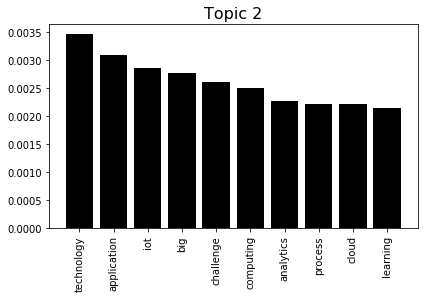

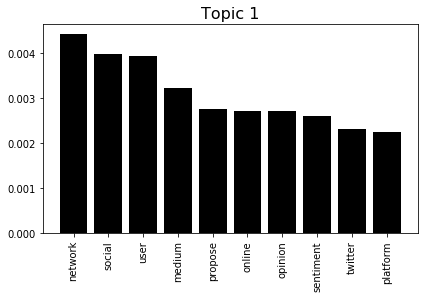

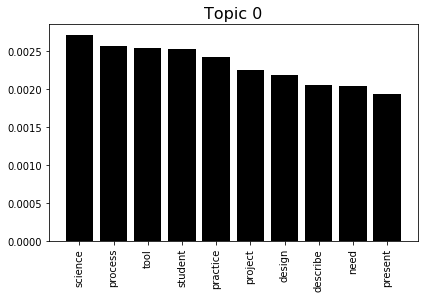

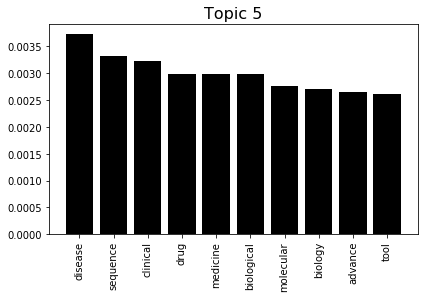

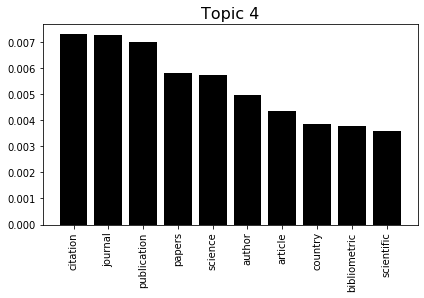

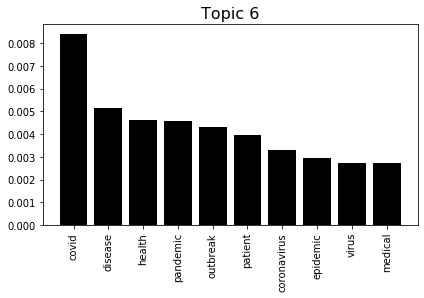

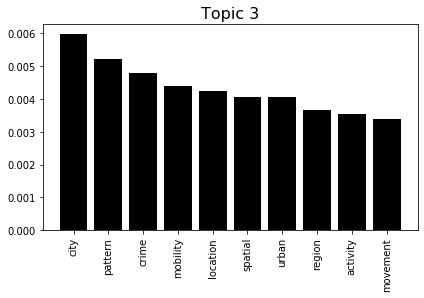

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i in result20[2]:
    word, distribution = zip(*result20[2][i])
    indices = np.arange(len(result20[2][i]))
    plt.bar(indices, distribution, color='#000000')
    plt.xticks(indices, word, rotation='vertical')
    plt.tight_layout()
    plt.title('Topic '+ str(i), fontdict=dict(size=16))
    plt.show()

## 4. Discussion

The result of the HDP Topic Modeling analysis informs us what data science scholars were talking over the course of 30 years. It is important because it helps us reflect on the evolution of data science and detect future direction of this field. We can see that in the 1990s, topics in data science were more about techniques and methods, but the domains of where they are applied were unclear. In the 2000s, the topics started to be more domain-specific and the range of domains was also broaden. In the 2010s, the domains expands even more, indicating that data science is applied to many more fields over the time. The year of 2020, which is the present year, the topics remain diverse and we see emergences of new topics. From the result, we infer that biology and health care will remain as the longstanding topics of data science, and there will be more topics of cloud computing in combination of city development, such as Smart Cities.

The topics are not always identifiable which draws the limitation of the method we employed. We conclude the three reasons for topics to be unidentifiable:
* Words in the topics are non-English words
* Words in the topics are too general to make the topic distinctive
* The labeler's lack of domain knowledge

The labeling of the topics is a challenge in the field of Topic Modeling. In this project, we relied on human interpretation to label the topics. The subjectivity of human interpretation also brings bias in the the labeling. There are methods proposed to produce "objective" labeling of the topics. `tomotopy` Python package provides a function to label the topics automatically. The function is based on the paper _Automatic labeling of multinomial topic models_ (2007), which proposes probabilistic approaches to automatically labeling topic models in an objective way. This approach marks the next step for us as the continuation of the research question.